In [41]:
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from std_msgs.msg import String
import rosbag2_py

import sys
sys.path.append('/home/alexey/rtklib-py/src/')
import rtkcmn as cmn

import numpy as np
import yaml

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_messages(input_bag: str):
    reader = rosbag2_py.SequentialReader()
    reader.open(
        rosbag2_py.StorageOptions(uri=input_bag, storage_id="sqlite3"),
        rosbag2_py.ConverterOptions(
            input_serialization_format="cdr", output_serialization_format="cdr"
        ),
    )

    topic_types = reader.get_all_topics_and_types()

    def typename(topic_name):
        for topic_type in topic_types:
            if topic_type.name == topic_name:
                return topic_type.type
        raise ValueError(f"topic {topic_name} not in bag")

    while reader.has_next():
        topic, data, timestamp = reader.read_next()
        msg_type = get_message(typename(topic))
        msg = deserialize_message(data, msg_type)
        yield topic, msg, timestamp
    del reader

In [3]:
# gt_tts_arr = []
# gt_llh_arr = []
# with open('gnss.yaml', 'r') as fd:
#     msgs = yaml.safe_load_all(fd)
#     for msg in msgs:
#         if msg is None:
#             continue
#         if msg['status']['status'] < 1:
#             continue
#         llh = [msg['latitude'], msg['longitude'], msg['altitude']]
#         gt_llh_arr.append(llh)
# gt_llh_arr = np.array(gt_llh_arr)        

#         gt_tts_arr.append(msg['header']['stamp']['secs'])

In [4]:
# gt_tts_arr

In [43]:
gt_tts_arr = []
gt_llh_arr = []
gt_ecef_arr = []
gt_enu_arr = []
with open('raw.yaml', 'r') as fd:
    msgs = yaml.safe_load_all(fd)
    for msg in msgs:
        if msg is None:
            continue
        if not msg['latlong_is_set']:
            continue
        llh = [msg['latlong']['latitude'], msg['latlong']['longitude'], msg['latlong']['altitude']]
        gt_llh_arr.append(llh)
        gt_ecef_arr.append(cmn.pos2ecef(llh, isdeg=True))
        gt_enu_arr.append(cmn.ecef2enu(gt_ecef_arr[0], gt_ecef_arr[-1]))
gt_llh_arr = np.array(gt_llh_arr)    
gt_ecef_arr = np.array(gt_ecef_arr)
gt_enu_arr = np.array(gt_enu_arr)

ValueError: operands could not be broadcast together with shapes (188,2) (1297,2) 

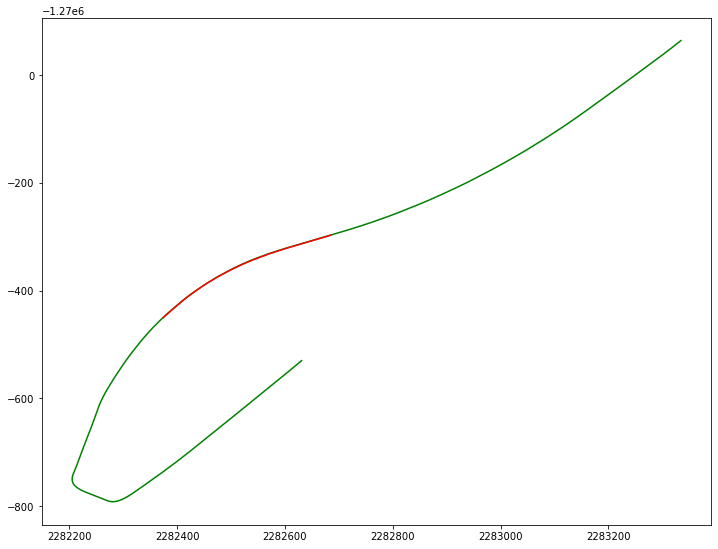

In [55]:

# BAG_PATH = '/home/alexey/gnssFGO/rosbag2_2024_04_21-23_38_12'
# BAG_PATH = '/home/alexey/gnssFGO/rosbag2_2024_04_21-23_54_22'
# BAG_PATH = '/home/alexey/gnssFGO/rosbag2_2024_04_22-00_00_52'
BAG_PATH = '/home/alexey/gnssFGO/rosbag2_2024_04_22-00_43_54'




tts_arr = []
llh_arr = []
ecef_arr = []
enu_arr = []
for topic, msg, timestamp in read_messages(BAG_PATH):
#     print(msg.latitude, msg.longitude, msg.altitude)
    llh = [msg.latitude, msg.longitude, msg.altitude]
    llh_arr.append(llh)
    ecef_arr.append(cmn.pos2ecef(llh, isdeg=True))
    enu_arr.append(cmn.ecef2enu(gt_ecef_arr[0], ecef_arr[-1]))
    
    tts_arr.append(msg.header.stamp.sec)
    
llh_arr = np.array(llh_arr)
ecef_arr = np.array(ecef_arr)
enu_arr = np.array(enu_arr)

plt.figure(figsize=(12,12))

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.plot(gt_enu_arr[:, 1], gt_enu_arr[:, 0], "g")
plt.plot(enu_arr[:, 1], enu_arr[:, 0], "r")

# plt.plot(gt_llh_arr[:, 1], gt_llh_arr[:, 0], "r")
# plt.plot(llh_arr[:, 1], llh_arr[:, 0], "g")

mean_error = np.linalg.norm(enu_arr[:, :2] - gt_enu_arr[:, :2])
plt.title("mean_error=%f" % mean_error)

plt.legend(['icp', 'fgo_lc'])


In [47]:
# enu_arr

In [ ]:

import yaml
import gtsam
import numpy as np

In [ ]:
icp_msgs = list(yaml.safe_load_all(open('/home/alexey/ros2_ws/raw.yaml')))


In [ ]:
msg0 = icp_msgs[0]
msg1 = icp_msgs[1]

ts0 = msg0['header']['stamp']['secs'] + msg0['header']['stamp']['nsecs'] * 1e-9
ts1 = msg1['header']['stamp']['secs'] + msg1['header']['stamp']['nsecs'] * 1e-9

dt = (ts1-ts0)

In [ ]:
qxyzw0 = msg0['orientation']['x'], msg0['orientation']['y'], msg0['orientation']['z'], msg0['orientation']['w']
vxyz0 = msg0['linear_velocity']['x'], msg0['linear_velocity']['y'], msg0['linear_velocity']['z']

qxyzw1 = msg1['orientation']['x'], msg1['orientation']['y'], msg1['orientation']['z'], msg1['orientation']['w']

In [ ]:
llh0 = msg0['latlong']['latitude'], msg0['latlong']['longitude'], msg0['latlong']['altitude']
llh1 = msg1['latlong']['latitude'], msg1['latlong']['longitude'], msg1['latlong']['altitude']

In [ ]:
ecef0 = cmn.pos2ecef(llh0, True)
ecef1 = cmn.pos2ecef(llh1, True)

In [ ]:
vel_ecef01 = (ecef1 - ecef0) / dt

In [ ]:
vel_ecef01

In [ ]:
def enuRe_Matrix_asLLH(llh):
    lat, lon = np.radians(llh[0]), np.radians(llh[1])
    sinPhi = np.sin(lat)
    cosPhi = np.cos(lat)
    sinLam = np.sin(lon)
    cosLam = np.cos(lon)
    R = np.zeros((3,3))
    R[0, 0] = -1 * sinLam
    R[0, 1] = cosLam
    R[0, 2] = 0
    
    R[1, 0] = -1 * sinPhi * cosLam
    R[1, 1] = -1 * sinPhi * sinLam
    R[1, 2] = cosPhi
    
    R[2, :] = cosPhi * cosLam, cosPhi * sinLam, sinPhi
    
    return R

def nedRe_Matrix_asLLH(llh):
    lat, lon = np.radians(llh[0]), np.radians(llh[1])
    sLat = np.sin(lat)
    sLon = np.sin(lon)
    cLat = np.cos(lat)
    cLon = np.cos(lon)

    R = np.zeros((3,3))

    R[0, :] = -sLat * cLon, -sLat * sLon, cLat
    R[1, :] = -sLon, cLon, 0.0
    R[2, :] = -cLat * cLon, -cLat * sLon, -sLat

    return R

def enu2ned(enu):
    R = np.zeros((3,3))
    R[0, 1] = 1
    R[1, 0] = 1
    R[2, 2] = -1
    return R @ enu

def ned2enu(ned):
    R = np.zeros((3,3))
    R[0, 1] = 1
    R[1, 0] = 1
    R[2, 2] = -1
    return R @ ned

In [ ]:
gtsam.Rot3(nedRe_Matrix_asLLH(llh0)).rotate(vel_ecef01)

In [ ]:
gtsam.Rot3(enuRe_Matrix_asLLH(llh0)).rotate(vel_ecef01)

In [ ]:
rot_enu = gtsam.Rot3(qxyzw0[-1], *qxyzw0[:3])

In [ ]:
rot_enu.unrotate(ned2enu(gtsam.Rot3(nedRe_Matrix_asLLH(llh0)).rotate(vel_ecef01)))

In [ ]:
rot_enu.unrotate(gtsam.Rot3(enuRe_Matrix_asLLH(llh0)).rotate(vel_ecef01))

In [ ]:
eRenu = gtsam.Rot3(enuRe_Matrix_asLLH(llh0)).inverse()

In [ ]:
q = eRenu.compose(rot_enu).toQuaternion()
print(q.x(), q.y(), q.z(), q.w())

In [ ]:
rot_enu.matrix()

In [ ]:
eRenu.compose(rot_enu).rotate(vxyz0)

In [ ]:
eRenu.rotate(rot_enu.rotate(vxyz0))

In [ ]:
gravity_ecef = -4.422821, -3.446226, -8.055375

In [ ]:
eRenu.rotate(np.array([0,0,-9.81]))

In [ ]:
eRenu.inverse().rotate(gravity_ecef)

In [ ]:
lacc_body = -0.6465894669294358, -0.4684399664402008, 9.617865180969238

In [ ]:
eRenu.compose(rot_enu).inverse().rotate(gravity_ecef) # + lacc_body

In [ ]:
gtsam.Rot3(0.872959251292491, 0.045767265622131605,  0.13594323770268815,  0.4662262745740213).unrotate(gravity_ecef)


In [ ]:
gtsam.Rot3(0.8243985266369425,  -0.03258431497919451, 0.30527486649126445,0.4755129730983642).unrotate(gravity_ecef)
